# Q1: Sampling a 2d target

In [2]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import pandas as pd

## 1.1 Direct sampling
insert derivation of transformation and sampling here

In [4]:
def sample_r(k, N=1):
    a = k/2
    b = 1/2
    return stats.gamma.rvs(a, scale=1/b, size=N)

def sample_theta(N=1):
    return stats.uniform.rvs(scale=2*np.pi, size=N)

In [5]:
def direct_sampling(k, N=100000):
    rs = sample_r(k=k, N=N)
    ts = sample_theta(N=N)

    xs = rs * np.cos(ts)
    ys = rs * np.sin(ts)

    return xs, ys

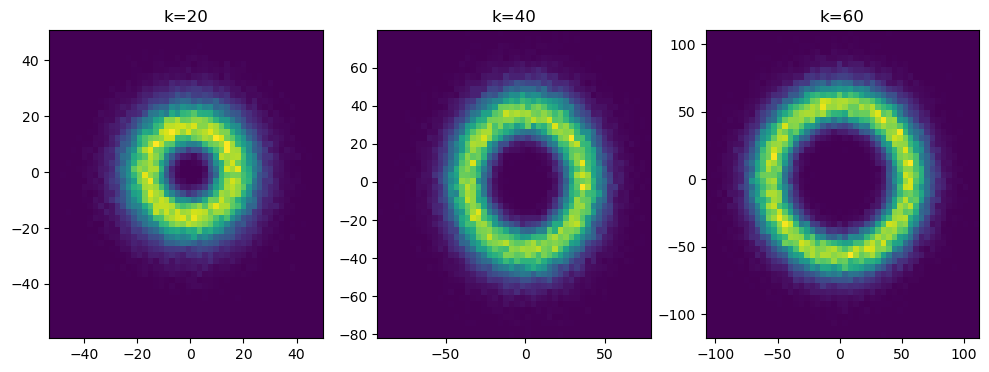

In [122]:
ks = [20, 40, 60]

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))

for i, k in enumerate(ks):
    x, y = direct_sampling(k=k)
    # ax[i].scatter(x, y, s=0.2, alpha=0.4)
    ax[i].hist2d(x, y, bins=50, cmap='viridis')
    ax[i].set_title(f'k={k}')
    
plt.show()

## 1.2 Metropolis-Hastings sampler

In [8]:
def target_distribution(x: float, y: float, k: int, epsilon: float = 10e-9) -> float:
    return max((x**2 + y**2)**(k/4 - 1) * np.exp(-(np.sqrt(x**2 + y**2)) / 2), epsilon)

In [9]:
def metropolis_hastings_random_walk(k, N=100000, sigma=1):
    x_samples, y_samples = [], []
    x, y = 0, 0
    samples_taken = 0

    progress_bar = tqdm(total=N, leave=True)
    while len(x_samples) < N:
        x1 = stats.norm.rvs(loc=x, scale=sigma)
        y1 = stats.norm.rvs(loc=y, scale=sigma)

        a = min(1, (target_distribution(x1, y1, k=k)) / (target_distribution(x, y, k=k)))
        
        if stats.uniform.rvs() < a:
            x_samples.append(x1)
            y_samples.append(y1)
            x, y = x1, y1
            progress_bar.update(1)
            
        samples_taken += 1

    # Compute acceptance rate
    acceptance_rate = N / samples_taken
    print(f"Acceptance rate: {acceptance_rate:.2f}")
            
    return np.array(x_samples), np.array(y_samples)

### identifying burn in for each k

In [219]:
mh_xs, mh_ys = [], []
for k in ks:
    x, y = metropolis_hastings_random_walk(k=k, sigma=(0.7*k))
    mh_xs.append(x)
    mh_ys.append(y)

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.48


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.38


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.33


We tune $\sigma$ by hand to reach a target acceptance rate within the range $(0.3, 0.5)$. This gives us an indication that the proposal sampler explores all if the target domain and also has good exploitation of high density areas in our target distribution.

It makes sense to scale sigma by $k$ as this correlates to the radius of the distribution which also scales roughly linearly according to $k$ (a can be seen in the direct sampling plots). We want a $k$ that allows us to jump from one side of the circle to the other with 

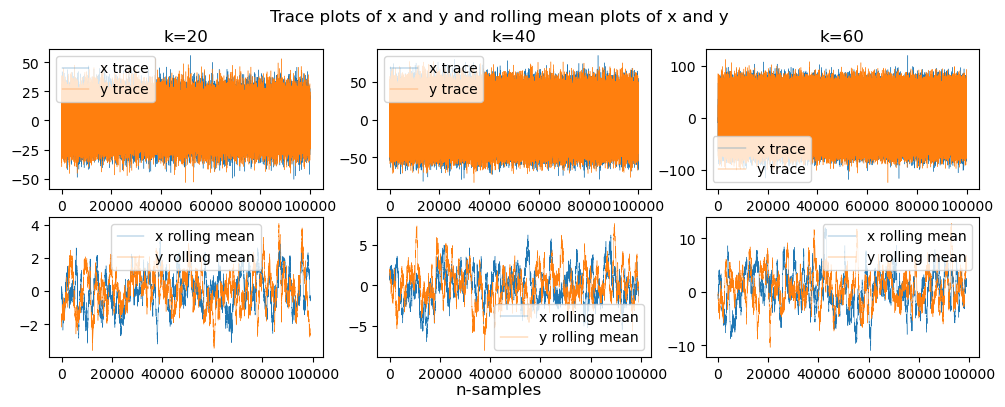

In [221]:
def moving_window_mean(data: list, window_size=100):
    return pd.Series(data).rolling(window=window_size).mean().to_numpy()[window_size-1:]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 4))

for i, (k, x, y) in enumerate(zip(ks, mh_xs, mh_ys)):
    ax[0][i].plot(x, label='x trace', lw=0.3)
    ax[0][i].plot(y, label='y trace', lw=0.3)
    ax[0][i].set_title(f"k={k}")
    ax[0][i].legend()
    
    x_running_mean = moving_window_mean(x.flatten().tolist(), window_size=1000)
    y_running_mean = moving_window_mean(y.flatten().tolist(), window_size=1000)
    ax[1][i].plot(x_running_mean, label='x rolling mean', lw=0.3)
    ax[1][i].plot(y_running_mean, label='y rolling mean', lw=0.3)
    ax[1][i].legend()
    
fig.supxlabel('n-samples')
fig.suptitle('Trace plots of x and y and rolling mean plots of x and y')
plt.show()

We can see that starting at $(0, 0)$, there is virtually no burn-in period. Immediately the samples randomly walk mean a mean of approximately 0 in both x and y dimensions.

We will still discard the first 10% (10,000) of samples for good measure.

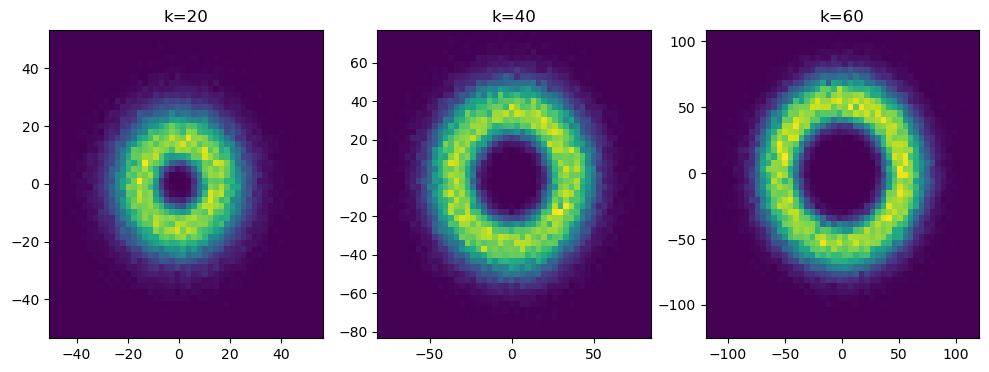

In [233]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
burnin = 10000
for i, (k, x, y) in enumerate(zip(ks, mh_xs, mh_ys)):
    # ax[i].scatter(x[burnin:], y[burnin:], s=0.2, alpha=0.4)
    ax[i].hist2d(x[burnin:], y[burnin:], bins=50, cmap='viridis')
    ax[i].set_title(f"k={k}")
plt.show()

## 1.3 Metropolis-adjusted Langevin algorithm (MALA)

In [17]:
def gradient_log_target(x, y, k, epsilon=1e-9):
    r_sq = x**2 + y**2 + epsilon
    factor = (k / 4 - 1) * 2 / r_sq
    def grad(v):
        nonlocal factor, r_sq
        return (factor - 1 / (2 * np.sqrt(r_sq))) * v
    return grad(x), grad(y)

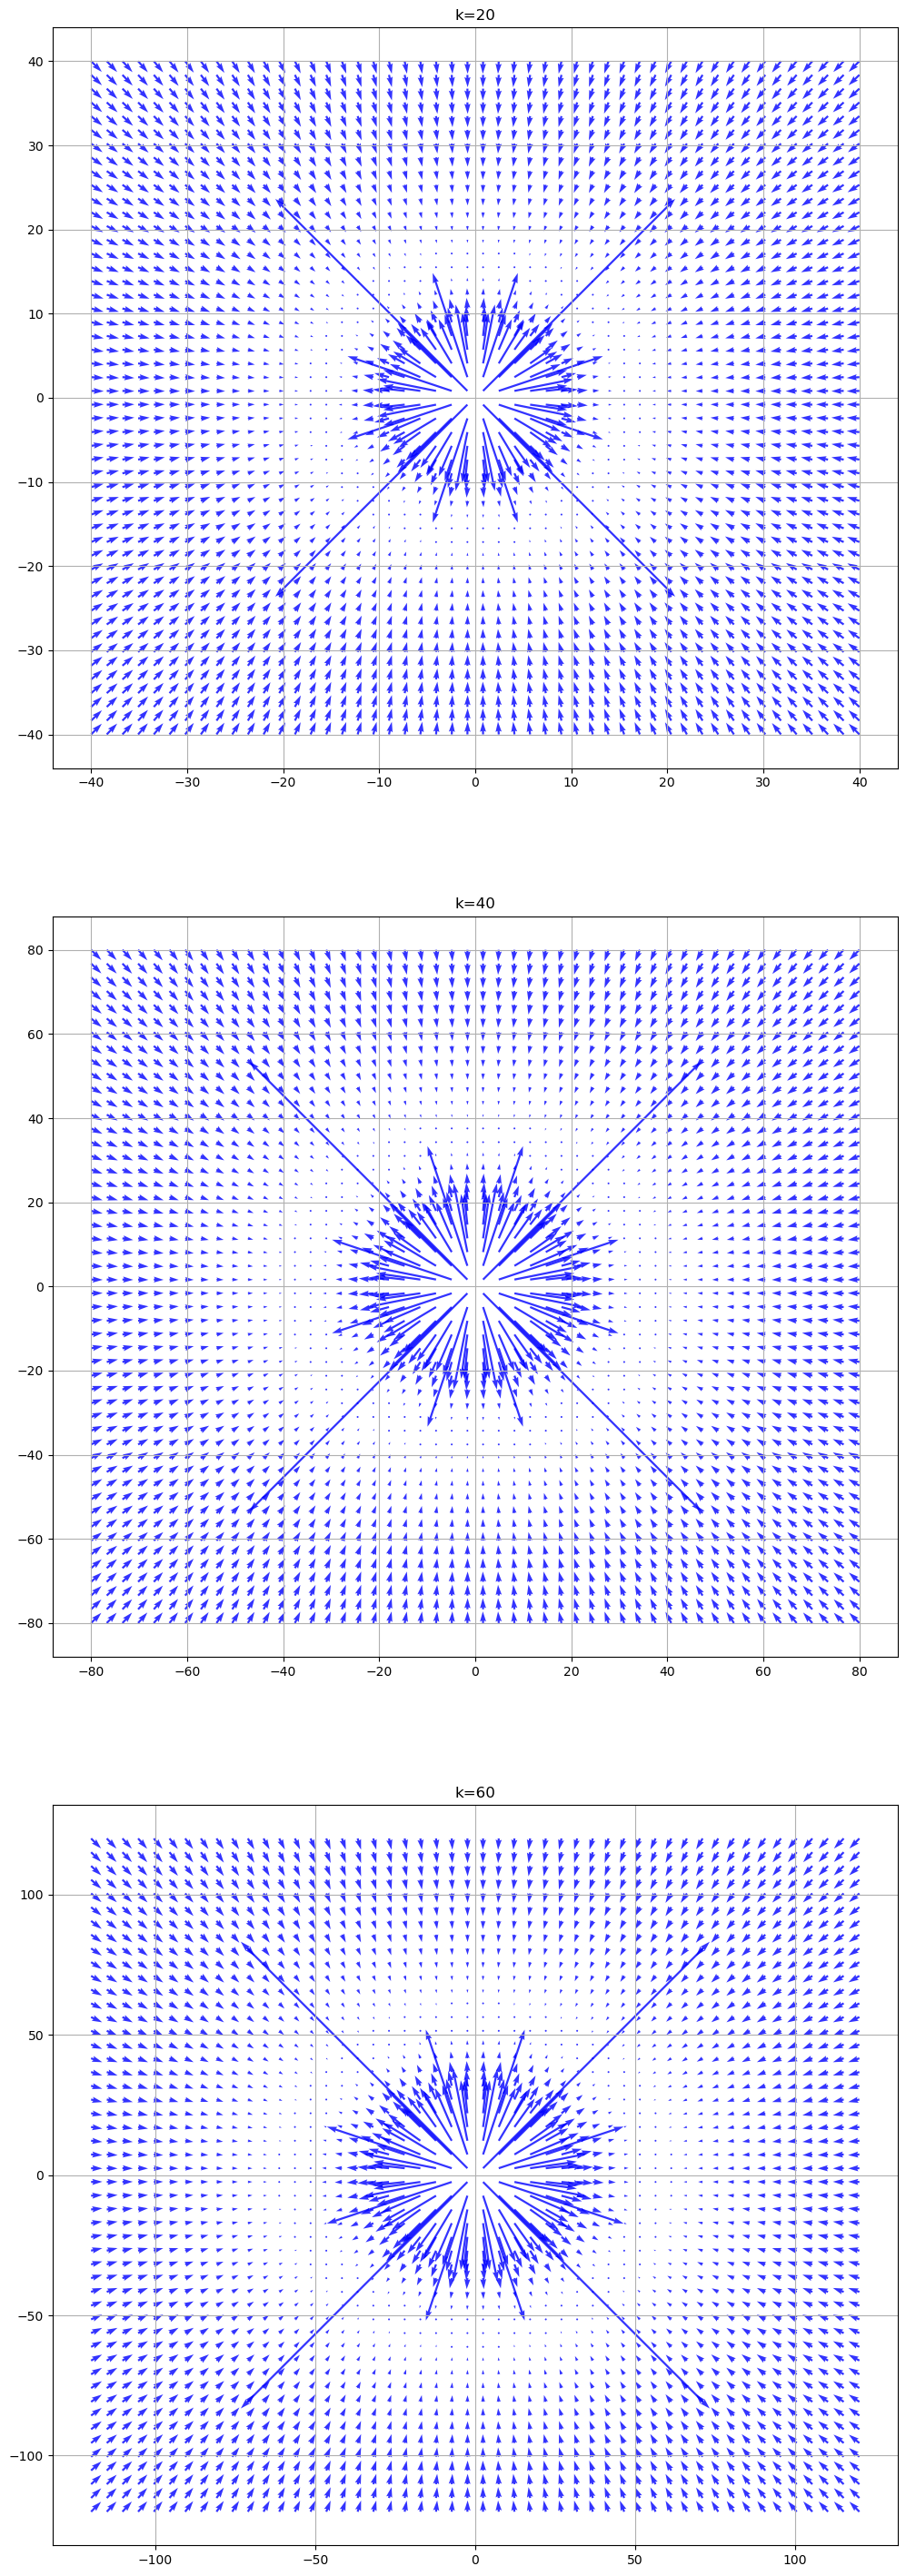

In [130]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(12, 36))
precision = 50
for i, k in enumerate(ks):
    ax[i].set_title(f"k={k}")
    
    x = np.linspace(-2*k, 2*k, precision)
    y = np.linspace(-2*k, 2*k, precision)
    x_mesh, y_mesh = np.meshgrid(x, y)
    
    gx, gy = gradient_log_target(x_mesh, y_mesh, k)
    
    ax[i].quiver(x_mesh, y_mesh, gx, gy, scale=20, color='blue', alpha=0.8)
    ax[i].grid(True)

plt.show()

In [201]:
def target_distribution_vector(v: np.array, k: int, epsilon: float = 10e-9) -> float:
    return max(np.sum(v ** 2)**(k/4 - 1) * np.exp(-(np.sqrt(np.sum(v ** 2))) / 2), epsilon)
    
def gradient_log_target_vector(v, k, epsilon=1e-9):
    r_sq = np.sum(v**2) + epsilon
    factor = (k / 4 - 1) * 2 / r_sq
    return (factor - 1 / (2 * np.sqrt(r_sq))) * v
    
def langevin_proposal(v, k, step_size, 
                      grad_log_target = gradient_log_target_vector):
    g = grad_log_target(v, k)
    s = step_size
    return stats.multivariate_normal.rvs(mean=v + (s * g), cov=2 * s * np.identity(2))

def langevin_pdf(v1, v, k, step_size, 
                 grad_log_target = gradient_log_target_vector):
    # probability of going from x -> x1 given langevin proposals
    g = grad_log_target(v, k)
    s = step_size
    return stats.multivariate_normal.pdf(v1, mean=v + (s * g), cov=2 * s * np.identity(2))

In [203]:
def metropolis_adjusted_langevin(k, step_size, N=100000, sigma=1, 
                                 target_dist = target_distribution_vector, 
                                 grad_log_target = gradient_log_target_vector):
    x_samples, y_samples = [], []
    v = np.array([0, 0])
    samples_taken = 0

    progress_bar = tqdm(total=N, leave=True)
    while len(x_samples) < N:
        v1 = langevin_proposal(v, k, step_size)

        a = min(
            1,
            (target_dist(v1, k=k) * langevin_pdf(v, v1, k, step_size, grad_log_target=grad_log_target)) /
            (target_dist(v, k=k) * langevin_pdf(v1, v, k, step_size, grad_log_target=grad_log_target))
        )
        
        if stats.uniform.rvs() < a:
            x_samples.append(v1[0])
            y_samples.append(v1[1])
            v = v1
            progress_bar.update(1)
            
        samples_taken += 1

    # Compute acceptance rate
    acceptance_rate = N / samples_taken
    print(f"Acceptance rate: {acceptance_rate:.2f}")
            
    return np.array(x_samples), np.array(y_samples)

In [214]:
mhl_xs, mhl_ys = [], []
for k in ks:
    x, y = metropolis_adjusted_langevin(k=k, sigma=(0.7*k), step_size=4*k)
    mhl_xs.append(x)
    mhl_ys.append(y)

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.54


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.51


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.50


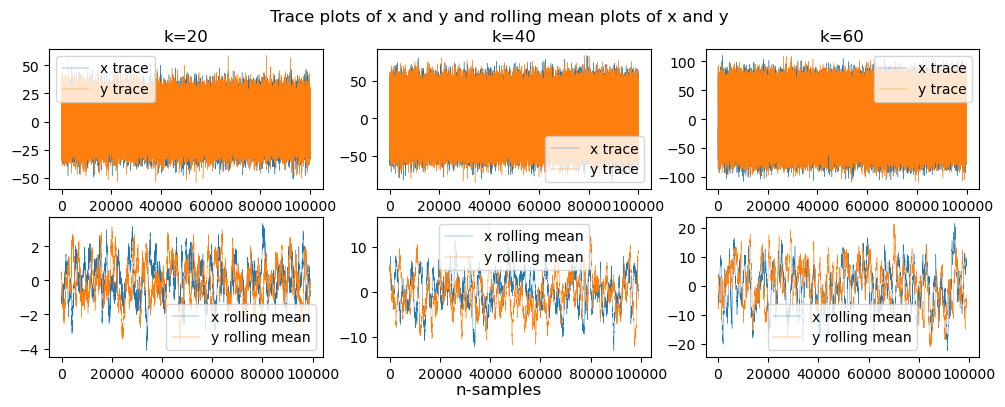

In [227]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 4))

for i, (k, x, y) in enumerate(zip(ks, mhl_xs, mhl_ys)):
    ax[0][i].plot(x, label='x trace', lw=0.3)
    ax[0][i].plot(y, label='y trace', lw=0.3)
    ax[0][i].set_title(f"k={k}")
    ax[0][i].legend()
    
    x_running_mean = moving_window_mean(x.flatten().tolist(), window_size=1000)
    y_running_mean = moving_window_mean(y.flatten().tolist(), window_size=1000)
    ax[1][i].plot(x_running_mean, label='x rolling mean', lw=0.3)
    ax[1][i].plot(y_running_mean, label='y rolling mean', lw=0.3)
    ax[1][i].legend()
    
fig.supxlabel('n-samples')
fig.suptitle('Trace plots of x and y and rolling mean plots of x and y')
plt.show()

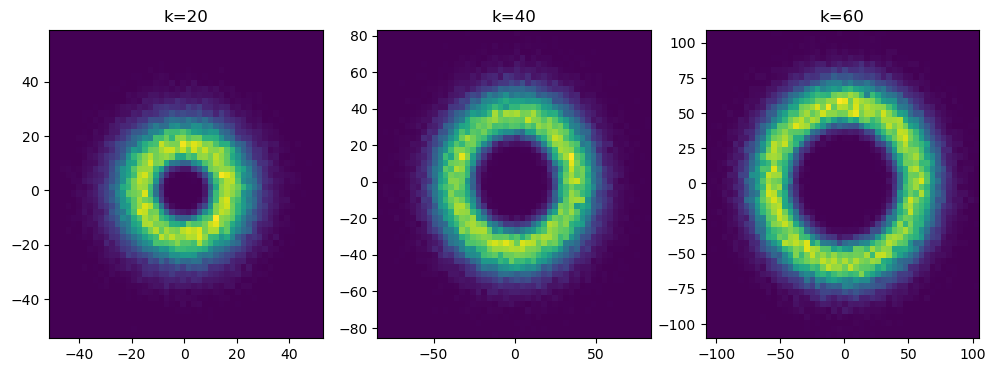

In [231]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
burnin = 10000
for i, (k, x, y) in enumerate(zip(ks, mhl_xs, mhl_ys)):
    # ax[i].scatter(x[burnin:], y[burnin:], s=0.2, alpha=0.4)
    ax[i].hist2d(x[burnin:], y[burnin:], bins=50, cmap='viridis')
    ax[i].set_title(f"k={k}")
plt.show()

## 1.4 Implementation of autocorrelation estimator

In [ ]:
def autocorrelation(samples: np.array, max_lag=100) -> np.array:
    x_bar = np.mean(samples)
    n = len(samples)
    var = np.var(samples)
    
    # return [COV / CAR for lag in range(1, max_range + 1)]
    return [np.sum(((samples[:n-lag] - x_bar) * (samples[lag:] - x_bar)) / (n - lag)) / var for lag in range(1, max_lag+1)]

### demonstration of autocorrelation estimator

In [ ]:
plt.stem(range(100), autocorrelation(mhl_xs[0][burnin:]), linefmt="red", markerfmt=" ")
plt.show()

## 1.5 Computing autocorrelation on each MH sampler for $k=40$, $N=100000$, $lag=100$

In [188]:
k=40
N=100000
max_lag=100

sigma = k
step_size= 5*k
burnin=10000

# generate samples with random walk and langevin samplers
samples = [
    metropolis_hastings_random_walk(k=k, N=N, sigma=sigma),
    metropolis_adjusted_langevin(k=k, N=N, sigma=sigma, step_size=step_size)
]

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.30


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.37


In [194]:
# remove burn in
samples_b = [(x[burnin:], y[burnin:]) for (x, y) in samples]
# calculate autocorrelation
autocorrs = [(autocorrelation(x, max_lag=max_lag), 
              autocorrelation(y, max_lag=max_lag))  
             for (x, y) in samples_b]

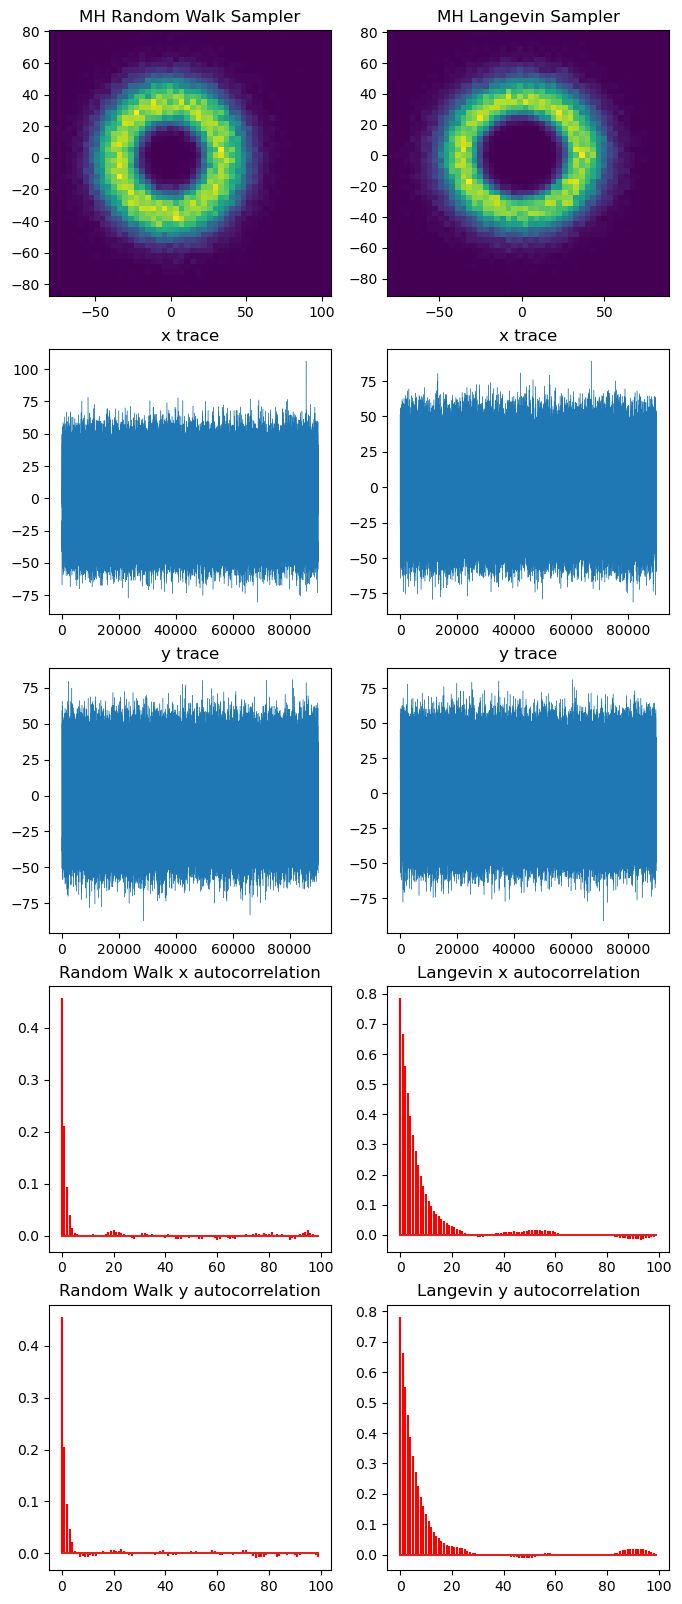

In [198]:
fix, ax = plt.subplots(ncols=2, nrows=5, figsize=(8, 20))

for i, ((x, y), (corr_x, corr_y)) in enumerate(zip(samples_b, autocorrs)):
    # plot density
    # ax[0][i].scatter(x, y, s=0.2, alpha=0.4)
    ax[0][i].hist2d(x, y, bins=50, cmap='viridis')
    
    # plot x and y traces
    ax[1][i].plot(x, label='x trace', lw=0.3)
    ax[2][i].plot(y, label='y trace', lw=0.3)
    ax[1][i].set_title('x trace')
    ax[2][i].set_title('y trace')
    
    # plot autocorrelation
    ax[3][i].stem(range(max_lag), corr_x, linefmt="red", markerfmt=" ")
    ax[4][i].stem(range(max_lag), corr_y, linefmt="red", markerfmt=" ")

ax[0][0].set_title('MH Random Walk Sampler')
ax[0][1].set_title('MH Langevin Sampler')

ax[3][0].set_title('Random Walk x autocorrelation')
ax[3][1].set_title('Langevin x autocorrelation')
ax[4][0].set_title('Random Walk y autocorrelation')
ax[4][1].set_title('Langevin y autocorrelation')

plt.show()

# Q2: Bayesian Inference with a GMM prior